# Analiza danych
## Zestaw tracks (utwory)

Zadanie dotyczy określenia charakterystyki utworu, jaką jest tryb (dur lub moll), zatem oczekujemy, że najważniejsze dane są zawarte w zestawie zawierającym utwory

In [3]:
# import great_expectations as gx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [6]:
df = pd.read_json("IUM23L_Zad_08_03_v1/tracks.jsonl", lines=True)
df_v2 = pd.read_json("IUM23L_Zad_08_03_v2/tracks.jsonl", lines=True)

# gdf = gx.from_pandas(df)

### Ogólne informacje o danych w tabeli 

#### Wnioski
* wiele column zawiera wartości null, w szczególności id, name, popularity, id_artist
* nie jest jasne co reprezentują dane kolumny (potrzebny opis)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129648 entries, 0 to 129647
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                103587 non-null  object 
 1   name              103775 non-null  object 
 2   popularity        103772 non-null  float64
 3   duration_ms       129648 non-null  int64  
 4   explicit          129648 non-null  int64  
 5   id_artist         103849 non-null  object 
 6   release_date      129648 non-null  object 
 7   danceability      129648 non-null  float64
 8   energy            129648 non-null  float64
 9   key               129648 non-null  int64  
 10  loudness          129648 non-null  float64
 11  speechiness       129648 non-null  float64
 12  acousticness      129648 non-null  float64
 13  instrumentalness  129648 non-null  float64
 14  liveness          129648 non-null  float64
 15  valence           129648 non-null  float64
 16  tempo             12

In [7]:
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129648 entries, 0 to 129647
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                129648 non-null  object 
 1   name              129648 non-null  object 
 2   popularity        129648 non-null  int64  
 3   duration_ms       129648 non-null  int64  
 4   explicit          129648 non-null  int64  
 5   id_artist         129648 non-null  object 
 6   release_date      129648 non-null  object 
 7   danceability      129648 non-null  float64
 8   energy            129648 non-null  float64
 9   key               129648 non-null  int64  
 10  mode              25929 non-null   float64
 11  loudness          129648 non-null  float64
 12  speechiness       129648 non-null  float64
 13  acousticness      129648 non-null  float64
 14  instrumentalness  129648 non-null  float64
 15  liveness          129648 non-null  float64
 16  valence           12

In [10]:
final_df = df_v2.drop(columns=["id", "name", "popularity", "duration_ms", "id_artist", "release_date"])
final_df = final_df.loc[final_df['mode'].notnull()]
final_df.info()

SyntaxError: invalid syntax (755657870.py, line 3)

In [ ]:
xgb_tree = xgb.XGBClassifier()
xgb_tree.fit(train_x, train_y)
pred = xgb_tree.predict(test_x)
acc = accuracy_score(test_y, pred)
acc

#### Szczegółowe informacje o kolumnie `id`

Wszystkie obecne id utworów są niepowtarzalne, jednak aż 20% obecnych utworów nie posiada `id`. Z tego powodu nie można zagwarantować, że w rzeczywistości są to różne utwory

In [55]:
gdf.expect_column_values_to_be_unique("id")

{
  "meta": {},
  "success": true,
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {
    "element_count": 129648,
    "missing_count": 26061,
    "missing_percent": 20.10135135135135,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  }
}

Jedynie 4 wiersze zawierają zdublowane dane (ale z tak dużą reprezentacją wartości null, nie jest to wiarygodna statystyka)

In [56]:
df.duplicated().value_counts()

False    129644
True          4
dtype: int64

#### Korelacja

W poniższej tabeli zaprezentowano korelację parametrów - daje się wyróżnić kilka szczególnie wysoko skorelowanych par (zestawienia zgadzają się z intuicyjnym rozumieniem tych parametrów): *energy*-*loudness*, *danceability*-*valence*; a także par z istotną korelacją ujemną: *energy*-*acousticness*, *loudness*-*acousticness*.

<Axes: >

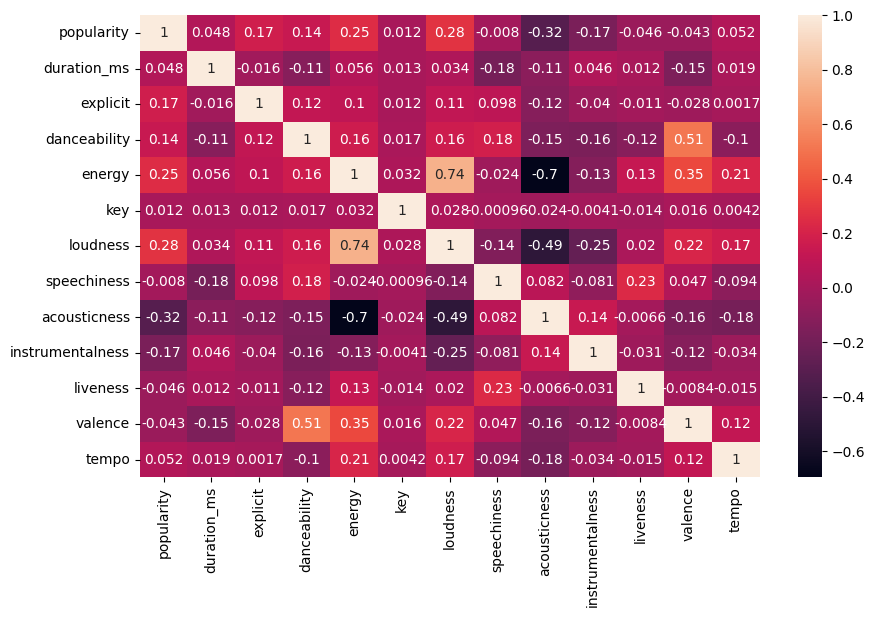

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)

### Analiza domenowa

W klasycznej muzyce europejskiej tonacja (ang. key) utworu decyduje o wyborze siedmiu z pośród dwunastu dźwięków skali chromatycznej. Tryb (dur/moll) utworu w uproszczeniu mówi o tym, wokół których dźwięków tak otrzymanej siedmiostopniowej skali oscyluje melodia i które akordy powodują powstanie napięcia i jego rozwiązanie - jeszcze prostszymi słowy, czy w utworze dominują akordy mollowe czy durowe.

W odbiorze utworu, zazwyczaj utwory w trybie durowym są uznawane za pozytywne i radosne, zaś utwory w trybie mollowym - za smutne czy melancholijne. Opis słowny tego zjawiska wydaje się odpowiadać blisko opisowi atrybutu `valence`:

```
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
```

W związku brakiem jakiegokolwiek zbioru testowego z poprawnie zdefiniowaną wartością trybu, jedną z propozycji może być użycie atrybutu `valence` jako obiektu klasyfikacji - dla użytkownika końcowego "nastrój" utworu jest więcej mówiącą cechą niż teoretyczny "tryb"

#### Hipoteza o zależności charakteru utworu od tonacji

W teorii wybór tonacji nie decyduje o trybie (utwór może być w tonacji C-dur, jak i C-moll), jednakże w praktyce dla niektórych instrumentalistów pewne tonacje są prostsze od innych (na przykład prościej jest grać w skali C-dur niż w C-moll - w tej pierwszej pianista używa tylko białych klawiszy, a w tej drugiej - aż trzech czarnych). Z tego powodu powstała hipotezę, że dla klucza C przewagę powinny stanowić utwory durowe, czyli średnia wartość `valence` powinna być wysoka. Dla odmiany na przykład w kluczu A łatwiej grać w skali mollowej niż durowej, a zatem oczekiwane `valence` powinno być niskie.

Hipoteza jednak upadła. Tabela poniżej przedstawia średnią wartość `valence` dla każdego klucza - widać, że tonacja nie ma prawie żadnego wpływu na `valence`.

In [57]:
df["key"].replace({0: "C", 1: "C#", 2: "D", 3: "D#", 4: "E", 5: "F", 6: "F#", 7: "G", 8: "G#", 9: "A", 10: "A#", 11: "B"},
          inplace=True)

In [58]:
df.groupby(["key"]).mean()["valence"]

key
A     0.572955
A#    0.567601
B     0.571340
C     0.567314
C#    0.553516
D     0.557430
D#    0.537089
E     0.547899
F     0.574719
F#    0.561251
G     0.566676
G#    0.560948
Name: valence, dtype: float64

Na badanie może rzutować fakt, że pewnie tonacje (key) występują częściej niż pozostałe:

In [59]:
df.groupby(["key"]).size().sort_values(ascending=False)

key
C     16686
G     16466
A     15219
D     15118
F     11655
E     11090
B      8781
C#     8522
A#     7921
G#     7182
F#     6607
D#     4401
dtype: int64